# "머신러닝을 통한 접근 가이드" 목차
## 1. Library
## 2. Data Loading
## 3. Feature Engineering
### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
### 3-2. Feature Engineering
#### 3-2-1. Encoding
#### 3-2-2. Scailing
## 4. Modeling with Pycaret
## 5. Modeling with CatBoostRegressor

## 1. Library

In [1]:
# pip install pycaret

In [2]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np

# for "3-2. Feature Engineering"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler

# for "4. Modeling with Pycaret"
from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

## 2. Data Loading

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 3. Feature Engineering

### 3-1. Feature Generation
#### CODE SHARE WITH "파베르"님 
#### (https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent)
##### Feature Generation과 관련된 EDA는 위의 링크를 참조해주세요 :) 

In [4]:
# Train Data 불러오기 및 오류 데이터 제거
train = pd.read_csv('train.csv')
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train[~train['단지코드'].isin(train_error)].reset_index(drop=True)
print(train.shape)

(2869, 15)


In [5]:
# Test Data 불러오기 및 오류 데이터 제거
test = pd.read_csv('test.csv')
test_error = ['C2675', 'C2335', 'C1327']
test = test[~test['단지코드'].isin(test_error)].reset_index(drop=True)
print(test.shape)

(1008, 14)


---
1. 자격/공급유형 다시정리해보기
2. 서울같이 뺐던 데이터 뺄지말지 고민
3. 카테고리데이터 적극 찾아보기!!
---


In [6]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세' #행복주택/영구임대 묶기??!
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

차량보유인구비율, 전용면적(가중합), 차량미보유세대비율, 소형세대, 총입주민수, 임대료가중평균, 준공후기간(월) 추가

In [7]:
print(X_train.shape)
print(X_test.shape)

(411, 20)
(147, 19)


In [8]:
new_train = pd.read_csv('new_train3.csv')
new_test = pd.read_csv('new_test3.csv')

In [9]:
new_train.columns

Index(['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '상가수', '자격유형_major',
       '공급유형_major', '전용면적별세대수합', '전용면적별세대수합_myhome', '입주후기간(월)', '단지명', '주소',
       '총입주민수', '준공후기간(월)', '차량미보유세대수', '임대료', '임대보증금', '소형세대', '중형세대', '대형세대',
       '전용면적', '아파트수', '차량보유인구비율', '차량미보유세대비율'],
      dtype='object')

In [10]:
new_train = new_train[['단지코드', '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대',
                       '임대료', '총입주민수', '준공후기간(월)']]
new_test = new_test[['단지코드', '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대',
                     '임대료', '총입주민수', '준공후기간(월)']]
print(new_train.shape); print(new_test.shape)

(411, 8)
(147, 8)


In [11]:
X_train = pd.merge(X_train, new_train, on='단지코드', how='left')
X_test = pd.merge(X_test, new_test, on='단지코드', how='left')

In [12]:
X_train = X_train.set_index('단지코드')
X_test = X_test.set_index('단지코드')

In [13]:
print(X_train.shape)
print(X_test.shape)

(411, 27)
(147, 26)


---

---

### 3-2. Feature Engineering
- 필요성?

In [14]:
X_train.head(3)

# 1. 지역은 글자데이터이다.
## 한글은 Catboost 이외에는 받아들일 수 없기  때문에, Encoding 과정이 필요하다.
## 해결법  : 통계치를 반영한 Encoding과, One-Hot Encoding 모두 적용해준다.

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,차량보유인구비율,전용면적,차량미보유세대비율,소형세대,임대료,총입주민수,준공후기간(월)
단지코드,,,,,,,,,,,,,,,,,,,,,,,,,,,
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.400787,39.0,0.0,0.653211,119432.0,1196.0,133.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.417173,40.0,0.0,0.320724,171133.0,2886.0,128.0
C1945,755,경기도,6.0,1.0,3.0,734.0,730.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.425875,50.0,0.0,0.317881,187414.0,2069.0,131.0


In [15]:
X_train.describe()

# 2. 단위가 다르다.
## 총 세대수, 공가수는 "세대 수"를, "도보 ~~"는 근처의 "개수"를, "단지내주차면수"는 "면적"을 의미하는 등 의미하는 바가 다르다.
## 이 경우에는, Feature의 "Scale"을 동일하게 해주지 않으면 Machine Learning과정에서 가중치 학습에 있어서 오류가 있을 수 있다.
## 해결법 : Robust Scailing을 적용해준다. (Good for outliers)

# 3. 이상치가 보인다.
## "도보 10분 거리 내 버스정류장 수"를 확인하면, 75%까지는 4이나, max는 20인 것을 확인할 수 있다.
## "도보 10분 거리 내 지하철역~`"은 75%까지는 0이지만, max는 3인 것을 확인할 수 있다.
## 이상치는 Linear Regression Model에서 상대적으로 큰 영향력을 끼친다.
## 해결법 : 데이터를 살펴보고, 처리를 결정한다.

# 4. 의미 없는 Feature도 확인되었다.
## "임대건물구분_아파트"의 경우 모두가 1이다.
## 해결법 : 단순 제거해준다.

,총세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,임대건물구분_상가,임대건물구분_아파트,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,차량보유인구비율,전용면적,차량미보유세대비율,소형세대,임대료,총입주민수,준공후기간(월)
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.0,411.000000,411.000000,411.000000,411.000000,411.000000,411.00000,411.000000,411.000000,411.000000,411.000000,411.00000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,722.347932,13.416058,0.124088,3.708029,581.676399,564.318735,0.080292,1.0,0.026764,0.085158,0.746959,0.136253,0.080292,0.07056,0.783455,0.082725,0.119221,0.133820,0.07056,0.406021,43.939173,0.157250,0.474427,182194.788321,1577.457908,136.415879
std,407.850156,10.325419,0.384681,2.836592,360.180869,386.819089,0.272076,0.0,0.161590,0.279457,0.435284,0.343475,0.272076,0.25640,0.412392,0.275802,0.324444,0.340874,0.25640,0.017224,11.722553,0.345154,0.342216,114439.404292,873.324971,84.136431
min,26.000000,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.366161,25.000000,0.000000,0.000000,0.000000,22.000000,2.000000
25%,447.500000,5.000000,0.000000,2.000000,317.500000,286.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.400537,38.000000,0.000000,0.175289,112509.000000,947.500000,69.000000
50%,632.000000,13.000000,0.000000,3.000000,515.000000,505.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.405677,42.000000,0.000000,0.514151,153157.000000,1456.000000,133.000000
75%,922.000000,20.000000,0.000000,4.000000,776.000000,753.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.417544,48.000000,0.000000,0.741570,211376.000000,2064.000000,175.500000
max,2568.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.468448,84.000000,1.000000,1.000000,879892.000000,5841.000000,370.000000


In [16]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

In [17]:
print(X_train.shape); print(X_test.shape)

(411, 26)
(147, 25)


- 필요성 - 3. 이상치가 보인다

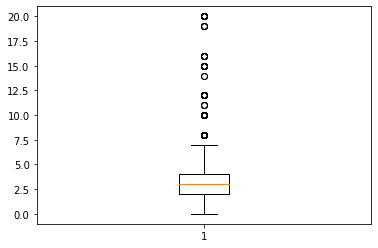

In [18]:
plt.boxplot([train['도보 10분거리 내 버스정류장 수']])
plt.show()

# 20에 가까운 값들이 존재하지만, 따로 처리해주기에는 독립적으로 떨어진 분포가 아니기 때문에, 제거하지 않는다.

In [19]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
# 여기서 지하철역 수가 3인 데이터 하나가 탈락함.
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    136
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
Name: 총세대수, dtype: int64

In [20]:
print(X_train.shape); print(X_test.shape)

(410, 26)
(147, 25)


#### 3-2-1. Encoding

In [21]:
%%time
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

Wall time: 238 ms


In [22]:
X_train.columns

Index(['총세대수', '공가수', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '임대건물구분_상가',
       '공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세',
       '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택', '자격유형_A', '자격유형_D',
       '자격유형_국민임대/장기전세_공급대상', '자격유형_영구임대_공급대상', '자격유형_행복주택_공급대상', '차량보유인구비율',
       '전용면적', '차량미보유세대비율', '소형세대', '임대료', '총입주민수', '준공후기간(월)', '지역_mean',
       '지역_median', '지역_std', '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'],
      dtype='object')

#### 3-2-2. Scailing

In [23]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료', '총입주민수', '준공후기간(월)',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'
                    ]

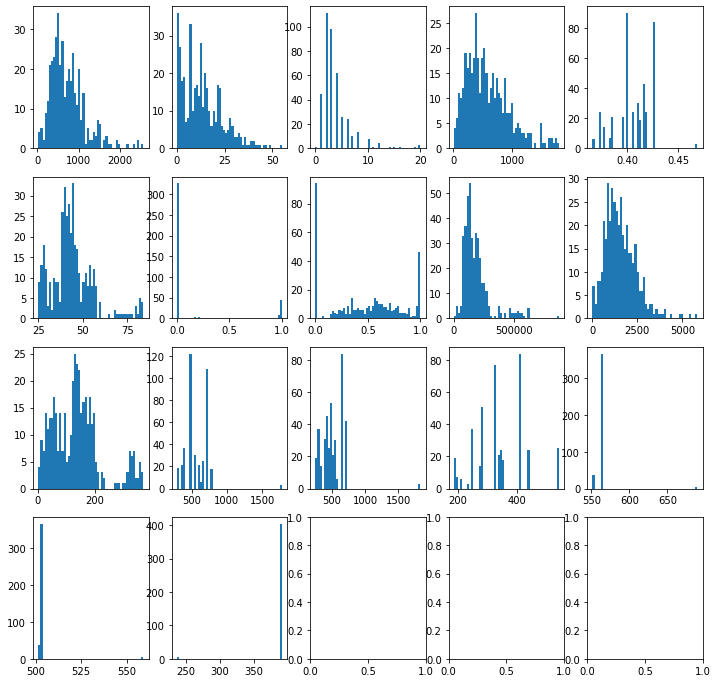

In [24]:
fig, axes = plt.subplots(4, 5, figsize= (12,12))

i = 0
for f in scailing_features:
    c = i % 5
    r = i // 5
    
    axes[r,c].hist(x = f, bins =50, data = X_train)
    i += 1
plt.show()


# 지역은 이상치가 확인 => Robust Scailing
# 도보 -> std 제거
# 나머지는 Standard

In [25]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

In [26]:
# 지역은  Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [27]:
# 나머지 Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '차량보유인구비율', '전용면적', '차량미보유세대비율', '소형세대', '임대료', '총입주민수', '준공후기간(월)',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

## 4. Modeling with pycaret

In [28]:
reg = setup(X_train, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = True, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
            numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(410, 29)"
3,Missing Values,False
4,Numeric Features,28
5,Categorical Features,0
6,Transformed Train Set,"(409, 28)"
7,Transformed Test Set,"(1, 28)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


- Top5의 모델 선택

In [29]:
# top5 = compare_models(n_select = 5, sort = 'MAE')

- Top5 Model Tuning

In [30]:
# models = []
# for m in top5:
#     models.append(tune_model(m, 
#                              optimize = 'MAE', 
#                              choose_better = True,
#                             n_iter = 30))

In [31]:
# voting = blend_models(models, optimize = 'MAE')
# voting = tune_model(voting, 
#                  optimize = 'MAE', 
#                  choose_better = True,
#                  n_iter = 30)

# voting = finalize_model(voting)
# sample = pd.read_csv('data/sample_submission.csv')
# layer1_pred = voting.predict(X_test)


In [32]:
# submission = pd.DataFrame(columns=['code', 'num'])
# submission['code']= X_test.index
# submission['num']= layer1_pred
# error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
# submission = pd.concat([submission, error]).reset_index(drop=True)
# submission.to_csv('pycaret3.csv', index=False)

# Modeling with Gradient Boosting Regressor

- Setting Data For Model

In [33]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

In [34]:
X.shape

(410, 28)

- Hyper params Tuning

In [35]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [36]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-26 21:30:37,720] A new study created in memory with name: cat_opt
[I 2021-07-26 21:30:38,355] Trial 0 finished with value: 117.54112483069889 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 117.54112483069889.
[I 2021-07-26 21:30:38,767] Trial 1 finished with value: 126.64606348077706 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 117.54112483069889.
[I 2021-07-26 21:30:38,958] Trial 2 finished with value: 125.25702567258189 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 117.54112483069889.
[I 2021-07-26 21:30:39,219] Trial 3 finished with value: 87.79196522625506 and parameters: {'max_depth':

Best Score: 87.79196522625506
Best trial: {'max_depth': 3, 'colsample_bylevel': 0.8608484485919076, 'subsample': 0.6673295021425665, 'min_child_samples': 46, 'max_bin': 287}


In [37]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [38]:
cat.fit(X, y, verbose = 0)
pred = cat.predict(X_test)

In [39]:
len(pred)

147

In [40]:
submission = pd.DataFrame(columns=['code', 'num'])
submission['code']= X_test.index
submission['num']= pred
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
submission = pd.concat([submission, error]).reset_index(drop=True)

In [41]:
submission['num'] = submission['num'].astype('float64')
submission.loc[submission['num']<0, 'num'] = 0
submission.to_csv('submission_cat6.csv', index=False)

In [42]:
pd.set_option('display.max_rows',500)
submission

,code,num
0,C1072,779.816962
1,C1128,1209.342509
2,C1456,521.099986
3,C1840,499.057458
4,C1332,1229.611331
5,C1563,2042.538230
6,C1794,832.684585
7,C1640,507.994508
8,C1377,307.867325
9,C2072,292.875232


- 변수중요도

In [43]:
from catboost import Pool
train_pool = Pool(X, y)

In [44]:
data = pd.DataFrame({'feature_importance': cat.get_feature_importance(train_pool), 
              'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

In [45]:
data

,feature_importance,feature_names
3,40.376417,단지내주차면수
21,21.157167,총입주민수
0,4.585801,총세대수
19,4.576386,소형세대
22,4.539804,준공후기간(월)
6,4.229281,공급유형_공공임대(5년/10년/분납/분양)
17,4.093798,전용면적
1,2.980813,공가수
20,2.608679,임대료
16,1.795331,차량보유인구비율


In [46]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
score = cross_val_score(cat, X, y, cv=kfold, scoring='neg_mean_absolute_error')

Learning rate set to 0.032684
0:	learn: 369.2480187	total: 1.25ms	remaining: 1.25s
1:	learn: 363.0753695	total: 2.19ms	remaining: 1.09s
2:	learn: 357.9081845	total: 3.08ms	remaining: 1.02s
3:	learn: 351.6682966	total: 4.26ms	remaining: 1.06s
4:	learn: 345.4510846	total: 5.5ms	remaining: 1.09s
5:	learn: 340.7456371	total: 6.45ms	remaining: 1.07s
6:	learn: 335.2929881	total: 7.37ms	remaining: 1.04s
7:	learn: 330.0092867	total: 8.02ms	remaining: 995ms
8:	learn: 325.1786187	total: 8.94ms	remaining: 985ms
9:	learn: 319.6512414	total: 9.76ms	remaining: 966ms
10:	learn: 314.6137061	total: 10.5ms	remaining: 943ms
11:	learn: 310.6615912	total: 11.5ms	remaining: 943ms
12:	learn: 306.1617073	total: 12.5ms	remaining: 949ms
13:	learn: 302.4318125	total: 13.8ms	remaining: 974ms
14:	learn: 297.7581416	total: 14.7ms	remaining: 964ms
15:	learn: 293.4074073	total: 15.9ms	remaining: 975ms
16:	learn: 289.7430629	total: 16.7ms	remaining: 965ms
17:	learn: 285.2628840	total: 17.7ms	remaining: 964ms
18:	learn

In [47]:
print(f'평균: {-score.mean()} | 표준편차: {score.std()}')

평균: 112.39400848306896 | 표준편차: 14.537099748891821


In [48]:
X.shape

(410, 28)

#### feature selection 안한 ver. public score :87.2994749246

---
---

- StratifiedK-Fold for Regression

In [49]:
# y_cat = pd.cut(y, 10, labels=range(10))
# skf = StratifiedKFold(5)

# preds = []
# for tr_id, val_id in skf.split(X, y_cat) : 
#     X_tr = X.iloc[tr_id]
#     y_tr = y.iloc[tr_id]
    
#     cat.fit(X_tr, y_tr, verbose = 0)
    
#     pred = cat.predict(X_test)
#     preds.append(pred)
# cat_pred = np.mean(preds, axis = 0)

In [50]:
# submission = pd.DataFrame(columns=['code', 'num'])
# submission['code']= X_test.index
# submission['num']= cat_pred
# error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
# submission = pd.concat([submission, error]).reset_index(drop=True)
# submission.to_csv('submission_cat.csv', index=False)

In [51]:
# submission['num'] = submission['num'].astype('float64')

In [52]:
# submission['num'] = submission['num'].astype('float64')
# submission.loc[submission['num']<0, 'num'] = 0
# submission.to_csv('submission_cat.csv', index=False)

In [53]:
# submission.info()

In [54]:
# from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
# model = CatBoostRegressor()
# summary = model.select_features(
#                 X,
#                 y=None,
#                 eval_set=None,
#                 features_for_select=None,
#                 num_features_to_select=None,
#                 algorithm=None,
#                 steps=None,
#                 shap_calc_type=None,
#                 train_final_model=False,
#                 verbose=None,
#                 logging_level=None,
#                 plot=False)

In [55]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)

In [56]:
# from catboost import Pool
# train_pool = Pool(X_train, y_train)
# eval_pool = Pool(X_test, y_test)

In [57]:
# model = CatBoostRegressor()
# summary = model.select_features(
#     train_pool,              # pool used for training
#     eval_set = eval_pool,
#     features_for_select= X.columns,
#     num_features_to_select=8,
#     algorithm = EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange
# )

---
---

### feature importance 기준 변수선택 : 1이상인것만 사용

In [58]:
X2 = X[data.loc[data['feature_importance']>=1, 'feature_names']]
X_test2 = X_test[data.loc[data['feature_importance']>=1, 'feature_names']]

In [59]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X2, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [60]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-26 21:32:55,508] A new study created in memory with name: cat_opt
[I 2021-07-26 21:32:55,922] Trial 0 finished with value: 95.0403797494359 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 95.0403797494359.
[I 2021-07-26 21:32:56,349] Trial 1 finished with value: 122.81376829591522 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 0 with value: 95.0403797494359.
[I 2021-07-26 21:32:56,676] Trial 2 finished with value: 118.66626134001882 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 0 with value: 95.0403797494359.
[I 2021-07-26 21:32:57,069] Trial 3 finished with value: 99.63988880802594 and parameters: {'max_depth': 3, 'col

Best Score: 89.99226839849224
Best trial: {'max_depth': 2, 'colsample_bylevel': 0.8990353820222541, 'subsample': 0.32407196478065287, 'min_child_samples': 92, 'max_bin': 277}


In [61]:
cat_p = study.best_trial.params
cat2 = CatBoostRegressor(**cat_p)

In [62]:
cat2.fit(X2, y, verbose = 0)
pred2 = cat2.predict(X_test2)

In [63]:
len(pred2)

147

In [64]:
submission2 = pd.DataFrame(columns=['code', 'num'])
submission2['code']= X_test2.index
submission2['num']= pred2
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])
submission2 = pd.concat([submission2, error]).reset_index(drop=True)

In [65]:
submission2['num'] = submission2['num'].astype('float64')
submission2.loc[submission2['num']<0, 'num'] = 0
submission2.to_csv('submission_cat7.csv', index=False)

In [66]:
pd.set_option('display.max_rows',500)
submission2

,code,num
0,C1072,752.138963
1,C1128,1183.131242
2,C1456,454.632438
3,C1840,472.087951
4,C1332,1185.994499
5,C1563,2132.045528
6,C1794,859.266956
7,C1640,489.684126
8,C1377,323.365700
9,C2072,264.779548


In [67]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
score2 = cross_val_score(cat2, X2, y, cv=kfold, scoring='neg_mean_absolute_error')

Learning rate set to 0.032684
0:	learn: 368.4859609	total: 1.05ms	remaining: 1.05s
1:	learn: 362.6286402	total: 1.95ms	remaining: 971ms
2:	learn: 356.5644576	total: 2.73ms	remaining: 907ms
3:	learn: 352.2722857	total: 3.54ms	remaining: 882ms
4:	learn: 346.9463053	total: 4.26ms	remaining: 848ms
5:	learn: 341.9941674	total: 4.76ms	remaining: 789ms
6:	learn: 337.2893037	total: 5.38ms	remaining: 764ms
7:	learn: 332.0026247	total: 6.16ms	remaining: 764ms
8:	learn: 327.4487191	total: 6.7ms	remaining: 738ms
9:	learn: 323.0595148	total: 7.35ms	remaining: 727ms
10:	learn: 318.8012324	total: 8.12ms	remaining: 730ms
11:	learn: 314.8150978	total: 9.04ms	remaining: 744ms
12:	learn: 311.1843076	total: 9.79ms	remaining: 743ms
13:	learn: 307.0960060	total: 10.3ms	remaining: 724ms
14:	learn: 302.9572736	total: 11ms	remaining: 722ms
15:	learn: 299.8332749	total: 11.4ms	remaining: 703ms
16:	learn: 296.1270276	total: 11.9ms	remaining: 690ms
17:	learn: 292.5597037	total: 12.5ms	remaining: 685ms
18:	learn: 

In [68]:
print(f'평균: {-score2.mean()} | 표준편차: {score2.std()}')

평균: 115.2560899770006 | 표준편차: 14.96626181916088


In [69]:
train_pool2 = Pool(X2, y)

data = pd.DataFrame({'feature_importance': cat2.get_feature_importance(train_pool2), 
              'feature_names': X2.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data

,feature_importance,feature_names
0,56.083445,단지내주차면수
1,12.110948,총입주민수
6,4.528170,전용면적
3,4.469227,소형세대
2,3.684955,총세대수
4,3.558069,준공후기간(월)
8,3.345186,임대료
5,2.734377,공급유형_공공임대(5년/10년/분납/분양)
7,2.167627,공가수
11,1.793652,차량미보유세대비율


#### feature selection ver. public score: 91.664825459	